In [2]:
def compute_groups(x):
    groups = {}
    for item in x:
        try:
            groups[item] = groups[item] +1
        except KeyError:
            groups[item] = 1
    return groups

def get_result(x):
    test = x['test']
    results = {}
    for key,value in test.items():
        try:
            results[key] = value/x[key]
        except KeyError:
            results[key] = value
    return results
    
def eval_few_shot(pred,percentile,ks=[5,15,20,30]):

    top_k = lambda k: pred.argsort(axis=1,descending=True)[:,:k]
    real = validation.target['phenotype'].to(torch.int64)
    result ={}
    for k in ks:
        top = top_k(k)
        top_pred = torch.gather(real,1,top)
        percentile_aux = percentile.copy()
        percentile_aux.loc[0,0] =None
        percentile_aux = percentile_aux.sort_index()
        top_k_g = pd.DataFrame((top+1)*top_pred).applymap(lambda x:percentile_aux.iloc[x.item()].values[0])
        evaluation = grp.copy()
        evaluation['test'] = top_k_g.apply(compute_groups,axis=1)
        result[k] = evaluation.apply(get_result,axis=1).apply(pd.Series).mean()
    return result

In [3]:
def load_model(device='cpu',n_layer=1,ancestry='full',embedding_size=512,dataset='mimic'):
    model = OutcomeModel(embedding_size = embedding_size,n_layers=n_layer,output_pathway = [283])


    model.load_state_dict(torch.load(f"models/{dataset}/['diagnoses']/['phenotype']/normal/its:1/dropout/ccs/[283]/25/256/ancestry:{ancestry}/SW-Phenotype-{n_layer}-{embedding_size}",map_location='cpu'))

    model = model.to(device)
    model.eval()
    return model

In [9]:
import sys
sys.path.append("..")

from models import OutcomeModel
from dataset_parsers.MIMIC3 import MIMIC_3
from dataset_parsers.eICU import eICU
from utilities import *
from Processing import *
from graph_builders.single import SingleGraph as Graph
import pandas as pd
import networkx as nx
from ICDCodesGrouper import ICDCodesGrouper
icdgrouper = ICDCodesGrouper(ccs_path='../icd_files/CCS-SingleDiagnosisGrouper.txt',ccs_procedure_path='../icd_files/CCS-SingleProceduresGrouper.txt')

In [12]:
#Do this for eICU
dataset_name = 'mimic'

if dataset_name == 'mimic':
    mimic_path =  "../Datasets/MIMIC_3/"
    dataset = MIMIC_3(mimic_path)
    frequency_mimic = dataset.get_tabular().diagnoses.apply(lambda x: icdgrouper.lookup('ccs',x)).value_counts()
    mimic_visits = dataset.get_tabular(dropna=False).HADM_ID.nunique()
    cuts = pd.cut((frequency_mimic/mimic_visits).values,5,labels=["0-20","20-40","40-60","60-80","80-100"])
    percentile = pd.DataFrame(index=frequency_mimic.index,data=cuts)
    percentile =  pd.DataFrame(icdgrouper.get_classes('ccs')).set_index(0).merge(percentile,right_index=True,left_index=True,how='outer').fillna("0-20").sort_index()
else:
    eicu_path =  "../Datasets/eICU/"
    dataset = eICU(eicu_path)
    df = dataset.get_tabular()
    frequency_eicu = df.groupby("patientunitstayid")['diagnoses'].apply(set).explode().apply(lambda x: icdgrouper.lookup('ccs',x)).value_counts()
    eicu_visits = df.patientunitstayid.nunique()
    cuts = pd.cut((frequency_eicu/eicu_visits).values,5,labels=["0-20","20-40","40-60","60-80","80-100"])
    percentile = pd.DataFrame(index=frequency_eicu.index,data=cuts)
    percentile =  pd.DataFrame(icdgrouper.get_classes('ccs')).set_index(0).merge(percentile,right_index=True,left_index=True,how='outer').fillna("0-20").sort_index()

In [14]:
%%time
df = dataset.to_self_supervised(target_grouper = {"phenotype":lambda x: icdgrouper.lookup('ccs',x)})

df = df.sample(5000)#this will fail if you did not retrieve the full dataset.


Wall time: 548 ms


In [10]:
tasks = ['phenotype']
from sklearn.preprocessing import MultiLabelBinarizer
all_classes = icdgrouper.get_classes('ccs')
mlb = MultiLabelBinarizer(classes=all_classes)
multi_hot = mlb.fit_transform(df.phenotype)
df.phenotype = list(multi_hot)
x = df.diagnoses.values
y ={}
for task in tasks:
    dim = len(np.array(list(df[task])).shape)
    y[task] = multi_hot


In [11]:
device = 'cpu'
embedding_size = 512
n_layer = 1
f_name = "../icd_files/CCS-MultiDiagnosisGrouper.txt"



In [12]:
real = y[tasks[0]]
df = pd.DataFrame(real).T
df.index = percentile.values
grp = df.groupby(df.index).apply(sum)
grp = grp.T
grp.columns = ["0-20","20-40","40-60","60-80","80-100"]
ancestries = ['full','partial','no']

results = []
for ancestry in ancestries:
    G,idx,hierarchy = get_or_create_diagnosis_ccs_graph(nx.DiGraph(),f_name,connected=ancestry in ['full','no'],return_idx=True)

    model = load_model(device=device,n_layer=n_layer,ancestry=ancestry,embedding_size=embedding_size,dataset=dataset_name)
    if ancestry =='no':
        G =nx.subgraph(G, list(idx.keys()))
        embeddings = init_embeddings(embedding_size,poincare = True,G=G) 
        embeddings = embeddings[list(idx.values())]
    else:
        embeddings = init_embeddings(embedding_size,poincare = True,G=G) 
    #I think this can be optimized.
    validation = get_or_load_data(patients = x,target=y,G = G,embedding_size = embedding_size,graph_type=Graph,embeddings=embeddings,replicate=False,random=False).to(device)
    out = model(validation)
    results.append(eval_few_shot(out[0],percentile))

This should never happen.. V173
This should never happen.. V173


/notebooks/Experiments/Notebooks/utilities.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_tensor = lambda x:torch.tensor(x).float()


This should never happen.. V173


/notebooks/Experiments/Notebooks/utilities.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_tensor = lambda x:torch.tensor(x).float()


In [13]:
df = pd.concat([pd.DataFrame(item) for item in results],axis=1)
ks = [5,15,20,30]
index = pd.MultiIndex.from_product([ancestries,ks])
df = df.T[grp.columns]
df.index = index
df = df.T
df = df.applymap(lambda x: round(x,2))

<AxesSubplot:>

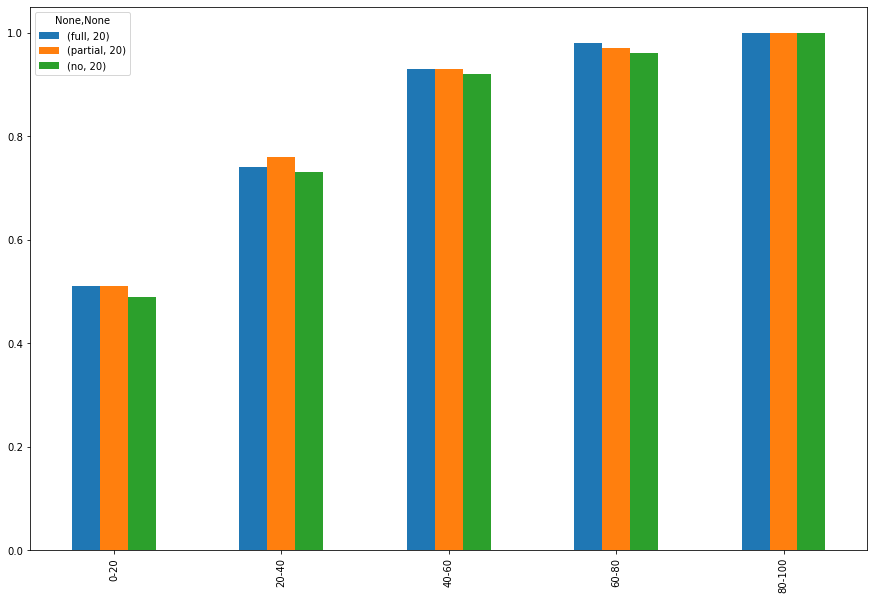

In [15]:
df.loc[:, (slice(None), 20)].plot(kind='bar',figsize=(15,10))


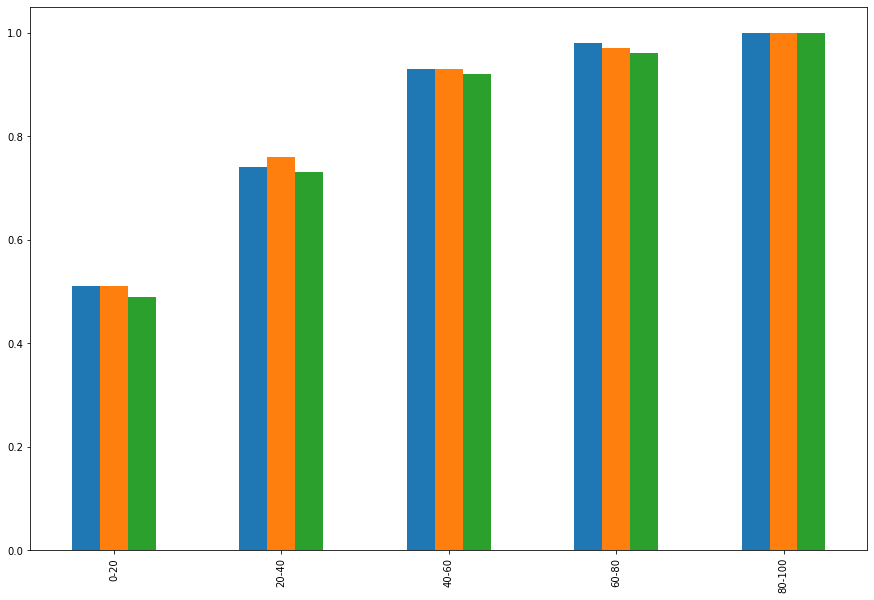

In [26]:
df.loc[:, (slice(None), 20)].plot(kind='bar',figsize=(15,10),legend=False).get_figure().savefig("fewshotm.png")